<a href="https://colab.research.google.com/github/Le4o/topicos-avancados-ic/blob/main/Avalia%C3%A7%C3%A3o_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação 1
#### Exercício da matéria de Tópicos Avançados em Inteligência Computacional

Grupo:
- João Victor de Sledz Bulhões
- Leonardo de Andrade Santana
- Lis da Silva Azevedo

### Definição do Exercício
Utilizaremos o banco de dados do Human Activity Recognition with Smartphones, que foi construído a partir das gravações dos participantes do estudo realizando atividades da vida diária enquanto carregavam um smartphone com sensores inerciais embutidos. Para cada registro no conjunto de dados, é fornecido:

- Aceleração triaxial do acelerômetro (aceleração total) e a aceleração corporal estimada.

- Velocidade angular triaxial do giroscópio.

- Um vetor de 561 atributos com variáveis de domínio de tempo e frequência.

- O rótulo da atividade.

### Objetivo:
* Construir um modelo robusto para classificação das atividades diárias, utilizando o banco de dados fornecido, em uma das seis ações disponíveis:
> 1. caminhar;
> 2. subir escadas;
> 3. descer escadas;
> 4. sentar;
> 5. ficar em pé;
> 6. deitar.

* Desenvolver 4 modelos, utilizando:
> 1. Multi-Layer Perceptron (MLP)
> 2. Convolutional Neural Network (CNN)
> 3. Recurrent Neural Network (RNN)
> 4. Arquitetura hibrida com a combinação das redes anteriore

* Considere a divisão entre treinamento, validação e teste de 50%, 25% e 25%, respectivamente.

* Utilizar como métricas: **precision, recall, specificity,
F1-Score e accuracy**, evidenciando que o modelo não sofreu de **over/underfitting**.

### Observação: 
*   *Apresentação de métricas, gráficos, são essenciais para entendimento dos modelos e justificativas.*
*   *Compare ao final em uma tabela e apresente que técnica obteve os melhores
resultados, discutindo-os à luz de seu conhecimento sobre o assunto, discutindo
se eram resultados esperados, se estão adequados, e os porquês.*

### Opcionais:

*   A utilização de redes neurais baseadas em transformers é opcional e adicionará **1,0 ponto extra** ao projeto.
*   A utilização de pré-processamento das séries com Wavelets OU transformadas de Fourier adicionará **1,0 ponto extra** ao projeto.


### Link:

* [Mais informações sobre os recursos estão disponíveis no site](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) 


In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Datasets

Mounted at /content/drive/
/content/drive/My Drive/Datasets


In [109]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow_addons as tfa
import keras_metrics
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
tf.get_logger().setLevel('ERROR')

## Carregando os dados

O dataset fornecido é segmentado em **70% treino e 30% teste**, porém a atividade pede para segmentar em: **50% treino, 25% validação e 25% teste.** Então nos primeiramente juntamos os dados.


In [3]:
# Carregando os dados diretamente dos csvs do Human Activity Recognition with Smartphones
train_data = pd.read_csv('./uci_har_csvs/train.csv')
test_data = pd.read_csv('./uci_har_csvs/test.csv')

print(f'Shape of train data is: {train_data.shape}\nShape of test data is: {test_data.shape}')

data = train_data.append(test_data)
data.shape

print(f'Shape of combined data is {data.shape}')

Shape of train data is: (7352, 563)
Shape of test data is: (2947, 563)
Shape of combined data is (10299, 563)


## Analise inicial dos dados

O dataset possui 6 classes, sendo elas:


1.   Walking downstairs
2.   Walking Upstairs
3.   Walking
4.   Sitting
5.   Stading 
6.   Laying



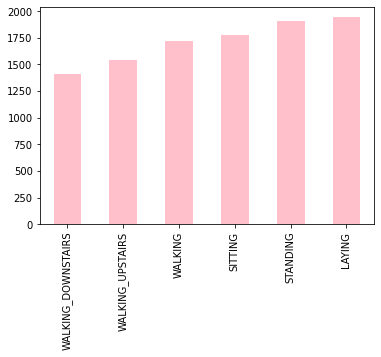

In [4]:
class_count = len(data['Activity'].unique())
data['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'pink')

## Segmentação do Dataset

50% treino, 25% validação e 25% teste


In [5]:
train, validate, test = \
              np.split(data.sample(frac=1, random_state=42), 
                       [int(.5*len(data)), int(.75*len(data))])
              
print(f'Shape of train data is {train.shape}')
print(f'Shape of validation data is {validate.shape}')
print(f'Shape of test data is {test.shape}')
validate.head()

Shape of train data is (5149, 563)
Shape of validation data is (2575, 563)
Shape of test data is (2575, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
2117,0.274369,-0.016706,-0.110229,-0.991515,-0.989040,-0.978536,-0.992510,-0.990249,-0.980843,-0.936067,-0.561457,-0.812424,0.841441,0.691739,0.824627,-0.989752,-0.999926,-0.999935,-0.999490,-0.994133,-0.991564,-0.983694,-0.570835,-0.632256,-0.525435,0.194450,-0.146492,-0.041534,0.385220,0.146668,0.008702,0.117522,0.316987,0.049494,0.002990,0.077043,-0.040535,-0.326617,-0.124434,-0.467705,...,-1.000000,-1.000000,0.189798,-0.435028,-0.826468,-0.983336,-0.983446,-0.979036,-0.988786,-0.996133,-0.983336,-0.999768,-0.973804,-0.651509,-1.0,-0.200696,-0.692462,-0.925401,-0.990613,-0.989842,-0.989335,-0.990264,-0.995010,-0.990613,-0.999922,-0.988997,-0.923452,-1.000000,-0.165418,-0.227327,-0.592258,-0.031017,-0.068529,0.222656,-0.171256,0.365294,-0.846661,-0.004809,11,LAYING
2937,0.260018,-0.008491,-0.117588,-0.935685,-0.670521,-0.875247,-0.959882,-0.805597,-0.907493,-0.892596,-0.146449,-0.774665,0.710398,0.541556,0.691246,-0.910007,-0.997606,-0.978016,-0.991313,-0.995422,-0.989595,-0.963853,-0.310086,-0.398456,-0.248864,-0.508756,0.476951,-0.460860,0.392226,-0.604299,0.591770,-0.713939,0.839213,-0.252033,0.355529,-1.000000,1.000000,0.296486,-0.012320,-0.867214,...,-0.476360,-1.000000,-0.455206,0.384570,0.087227,-0.512505,-0.269562,-0.408939,-0.192944,-0.049099,-0.512505,-0.740628,-0.801698,0.130729,-1.0,-0.259452,0.265055,-0.064927,-0.929913,-0.863376,-0.907363,-0.843969,-0.985603,-0.929913,-0.993913,-0.935197,-0.419270,-1.000000,-0.563006,0.783258,0.551519,0.351286,0.079468,0.329166,0.006809,-0.885412,0.113755,0.100170,16,SITTING
6867,0.278964,-0.016177,-0.112617,-0.986395,-0.993402,-0.996253,-0.987809,-0.994375,-0.995559,-0.935219,-0.566172,-0.826331,0.838379,0.692073,0.845662,-0.992035,-0.999849,-0.999965,-0.999920,-0.989898,-0.995405,-0.992992,-0.391655,-0.668624,-0.735404,0.074098,-0.024003,-0.086759,-0.050424,0.497133,-0.308945,0.436123,-0.284634,0.562480,-0.303941,0.243113,-0.238292,-0.560531,-0.482763,0.529234,...,-1.000000,-0.746032,0.201563,-0.661723,-0.919496,-0.963026,-0.936948,-0.955237,-0.922671,-0.973526,-0.963026,-0.998002,-0.980297,-0.

## Preparando os Dados para os Modelos

*   **x** = Todos os conjuntos de dados tirando as duas ultimas colunas.
*   **y** = Ultima coluna, coluna que define a atividade.



In [19]:
# Separando os os dados do target
x_train, y_train = train.iloc[:, :-2], train.iloc[:, -1:]
x_validate, y_validate = validate.iloc[:, :-2], validate.iloc[:, -1:]
x_test, y_test = test.iloc[:, :-2], test.iloc[:, -1:]
print(f'Train: {x_train.shape}, {y_train.shape}\nValidation: {x_validate.shape}, {y_validate.shape}\nTraining: {x_test.shape}, {y_test.shape}\n')

Train: (5149, 561), (5149, 1)
Validation: (2575, 561), (2575, 1)
Training: (2575, 561), (2575, 1)



Os modelos aceitam apenas números, então foi necessário alterar as strings que definem as classes para números.

In [20]:
# Trasformando as strings do target em números
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_validate = le.fit_transform(y_validate)
y_test = le.fit_transform(y_test)

# --------------Não sei oq é isso
scaling_data = MinMaxScaler()
x_train = scaling_data.fit_transform(x_train)
x_validate = scaling_data.fit_transform(x_validate)
x_test = scaling_data.transform(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [116]:
# Separando casos de teste do tipo LAYING
test_laying = test[test.Activity == 'LAYING']
x_test_laying, y_test_laying = test_laying.iloc[:, :-2], test_laying.iloc[:, -1:]
y_test_laying = le.fit_transform(y_test_laying)
x_test_laying = scaling_data.fit_transform(x_test_laying)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Multi-Layer Perceptron (MLP)

Perceptron é utilizado para classificação binária, possuindo apenas 1 neurônio, sendo assim, não podendo se aplicar a dados não lineares. 
O MLP foi desenvolvido para suprir com essa limitação.Ele possui camadas de entrada e saída e uma ou mais camadas ocultas com muitos neurônios juntos. E enquanto no Perceptron o neurônio deve ter uma função de ativação que impõe um limite, como ReLU ou sigmoid, os neurônios em um MLP podem usar qualquer função de ativação arbitrária.

Funções de ativação: 
*   **ReLU**: Função não linear que a não ativa todos os neurônios ao mesmo tempo. Se a entrada for negativa, ela será convertida em zero e o neurônio não será ativado. Isso significa que, ao mesmo tempo, apenas alguns neurônios são ativados, tornando a rede esparsa e eficiente e fácil para a computação.
*   **Softmax**: Alternativa para função sigmóide para lidar com problemas de classificação, já que a mesma é capaz de lidar com mais de 2 classes, diferente da sigmóide.




In [54]:
# Criando o model
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=x_train.shape[1])) # Layer 1
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(64, activation='relu')) # Layer 2
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(6, activation='softmax')) # Layer 3



*   **Compilação, Treino e validação**: O processo de treino foi composto por 20 epocas e 50% do dataset e a validação por 25% do dataset. 
>* Optimizer: [**Adam**](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) é um algoritmo de otimização que pode ser usado em vez do procedimento clássico de *Stochastic Gradient Descent* (mantém uma única taxa de aprendizado para todas as atualizações de peso e a taxa de aprendizado não muda durante o treinamento) para atualizar os pesos da rede iterativos com base nos dados de treinamento.
>* Loss: [sparse_categorical_crossentropy](https://vitalflux.com/keras-categorical-cross-entropy-loss-function/) Usado para modelos de classificação multi-classes quando a output label  sao valores inteiros (0, 1, 2,..).


In [110]:
# Compilando o model e treinando
model_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', 
                                                                                     keras_metrics.sparse_categorical_precision(), 
                                                                                     keras_metrics.sparse_categorical_recall(), 
                                                                                     keras_metrics.sparse_categorical_f1_score(), 
                                                                                     keras_metrics.sparse_categorical_true_negative()]) # optimizer 'adam'
history = model_mlp.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_validate, y_validate)) # teinando e validando 

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 2s 9ms/step - loss: 0.1218 - accuracy: 0.9514 - precision: 0.9967 - recall: 0.9815 - f1_score: 0.9890 - true_negative: 2121.1482 - val_loss: 0.0775 - val_accuracy: 0.9786 - val_precision: 0.9973 - val_recall: 0.9886 - val_f1_score: 0.9929 - val_true_negative: 5249.4878
Epoch 2/20
81/81 [==============================] - 0s 5ms/step - loss: 0.1023 - accuracy: 0.9606 - precision: 0.9951 - recall: 0.9905 - f1_score: 0.9928 - true_negative: 8361.5557 - val_loss: 0.0965 - val_accuracy: 0.9740 - val_precision: 0.9947 - val_recall: 0.9922 - val_f1_score: 0.9935 - val_true_negative: 11494.4883
Epoch 3/20
81/81 [==============================] - 0s 5ms/step - loss: 0.1140 - accuracy: 0.9542 - precision: 0.9948 - recall: 0.9910 - f1_score: 0.9929 - true_negative: 14608.6045 - val_loss: 0.0926 - val_accuracy: 0.9748 - val_precision: 0.9951 - val_recall: 0.9906 - val_f1_score: 0.9929 - val_true_negative: 17744.4883
Epoch 4/20
81/81 [========================

Testando o modelo com dataset de teste que equivale 50% do dataset total

In [114]:
# Testa o treino com todas as classes
test_results = model_mlp.evaluate(x_test, y_test, verbose=1)
print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[1]}\nSpecificity: {test_results[1]}')

81/81 [==============================] - 0s 2ms/step - loss: 0.0833 - accuracy: 0.9755 - precision: 0.9955 - recall: 0.9911 - f1_score: 0.9933 - true_negative: 132354.3125
Loss: 0.08334586024284363
Accuracy: 0.9755339622497559
Precision: 0.9954994320869446
Recall: 0.9910711646080017
F1 Score: 0.9755339622497559
Specificity: 0.9755339622497559


In [117]:
# Testa o treino apenas com a classe LAYING
test_results = model_mlp.evaluate(x_test_laying, y_test_laying, verbose=1)
print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[1]}\nSpecificity: {test_results[1]}')

15/15 [==============================] - 0s 2ms/step - loss: 1.2709 - accuracy: 0.8697 - precision: 0.9956 - recall: 0.9902 - f1_score: 0.9929 - true_negative: 133377.0000
Loss: 1.270925521850586
Accuracy: 0.8697478771209717
Precision: 0.9955660700798035
Recall: 0.9901862740516663
F1 Score: 0.8697478771209717
Specificity: 0.8697478771209717


# Convolutional Neural Network (CNN)
Uma **Artificial Neural Network (ANN)** é uma série de algoritmos que se esforçam para reconhecer relacionamentos subjacentes em um conjunto de dados, por meio de um processo que imita a maneira como o cérebro humano opera. As **ANN** podem se adaptar a mudanças de entrada para que a rede gere o melhor resultado possível sem a necessidade de redesenhar os critérios de saída.

As **Convolutional Neural Network (CNN)** são um tipo especializado de ANN que usam convolução no lugar da multiplicação geral da matriz em pelo menos uma de suas camadas.

In [118]:
n_timesteps, n_features, n_outputs = x_train.shape[0], x_train.shape[1], y_train.shape[0]

# Adicionando mais uma dimensão a x, para ficarem 3, como é pedido no Conv1D
x_train_cnn = x_train[..., None]
x_validate_cnn = x_validate[..., None]

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=x_train_cnn.shape[1:]))
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(10, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',
                                                                                     keras_metrics.sparse_categorical_precision(), 
                                                                                     keras_metrics.sparse_categorical_recall(), 
                                                                                     keras_metrics.sparse_categorical_f1_score(), 
                                                                                     keras_metrics.sparse_categorical_true_negative()])
history = model_cnn.fit(x_train_cnn, y_train, batch_size=64, epochs=20, validation_data=(x_validate_cnn, y_validate))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 12s 137ms/step - loss: 0.7435 - accuracy: 0.6992 - precision: 0.7364 - recall: 0.3092 - f1_score: 0.4159 - true_negative: 2099.5432 - val_loss: 0.3141 - val_accuracy: 0.8983 - val_precision: 0.9850 - val_recall: 0.7007 - val_f1_score: 0.8185 - val_true_negative: 5239.6343
Epoch 2/20
81/81 [==============================] - 11s 136ms/step - loss: 0.2169 - accuracy: 0.9114 - precision: 0.9859 - recall: 0.8068 - f1_score: 0.8871 - true_negative: 8340.7656 - val_loss: 0.1906 - val_accuracy: 0.9348 - val_precision: 0.9885 - val_recall: 0.8602 - val_f1_score: 0.9199 - val_true_negative: 11481.6338
Epoch 3/20
81/81 [==============================] - 11s 133ms/step - loss: 0.1482 - accuracy: 0.9425 - precision: 0.9888 - recall: 0.8893 - f1_score: 0.9364 - true_negative: 14592.0615 - val_loss: 0.1483 - val_accuracy: 0.9487 - val_precision: 0.9903 - val_recall: 0.9086 - val_f1_score: 0.9476 - val_true_negative: 17727.5117
Epoch 4/20
81/81 [===============

In [119]:
# Testando o model após treinamento
x_test_cnn = x_test[..., None]
test_results = model_cnn.evaluate(x_test, y_test, verbose=1)
print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[1]}\nSpecificity: {test_results[1]}')

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 2s 16ms/step - loss: 0.0784 - accuracy: 0.9670 - precision: 0.9979 - recall: 0.9868 - f1_score: 0.9923 - true_negative: 126133.4531
Loss: 0.07840050011873245
Accuracy: 0.9669902920722961
Precision: 0.9978524446487427
Recall: 0.9867883324623108
F1 Score: 0.9669902920722961
Specificity: 0.9669902920722961


In [126]:
# Testa o treino apenas com a classe LAYING
test_results = model_cnn.evaluate(x_test_laying, y_test_laying, verbose=1)
print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[1]}\nSpecificity: {test_results[1]}')

15/15 [==============================] - 0s 18ms/step - loss: 0.4492 - accuracy: 0.8676 - precision: 0.9979 - recall: 0.9859 - f1_score: 0.9919 - true_negative: 127156.0000
Loss: 0.44915956258773804
Accuracy: 0.8676470518112183
Precision: 0.9978809356689453
Recall: 0.9859211444854736
F1 Score: 0.8676470518112183
Specificity: 0.8676470518112183


# Recurrent Neural Network (RNN)

**Recurrent Neural Network (RNN)** tem uma conexão recorrente no *hidden state*. Essa restrição de loop garante que as informações sequenciais sejam capturadas nos dados de entrada.

In [121]:
x_train_rnn = x_train[..., None]
x_validate_rnn = x_validate[..., None]

model_rnn2 = keras.models.Sequential()
model_rnn2.add(keras.Input(shape=x_train_rnn.shape[1:])) 
model_rnn2.add(layers.SimpleRNN(128, return_sequences=True, activation='relu'))
model_rnn2.add(Flatten())
model_rnn2.add(layers.Dense(10))

model_rnn2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 561, 128)          16640     
                                                                 
 flatten_4 (Flatten)         (None, 71808)             0         
                                                                 
 dense_19 (Dense)            (None, 10)                718090    
                                                                 
Total params: 734,730
Trainable params: 734,730
Non-trainable params: 0
_________________________________________________________________


In [122]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy", 
            keras_metrics.sparse_categorical_precision(), 
            keras_metrics.sparse_categorical_recall(), 
            keras_metrics.sparse_categorical_f1_score(), 
            keras_metrics.sparse_categorical_true_negative()]

model_rnn2.compile(loss=loss, optimizer=optim, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [123]:
model_rnn2.fit(
    x_train_rnn, y_train, validation_data=(x_validate_rnn, y_validate), batch_size=64, epochs=10
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 25s 293ms/step - loss: 0.4316 - accuracy: 0.8167 - precision: 1.0557 - recall: 6.8735 - f1_score: 1.8087 - true_negative: 2986.3333 - val_loss: 0.1790 - val_accuracy: 0.9239 - val_precision: 2.7973 - val_recall: 10.4980 - val_f1_score: 4.4133 - val_true_negative: 13659.6094
Epoch 2/10
81/81 [==============================] - 22s 275ms/step - loss: 0.1167 - accuracy: 0.9528 - precision: 5.9735 - recall: 11.6948 - f1_score: 7.7328 - true_negative: 27463.0859 - val_loss: 0.1884 - val_accuracy: 0.9336 - val_precision: -684.0177 - val_recall: 12.2312 - val_f1_score: 25.4572 - val_true_negative: 44093.3398
Epoch 3/10
81/81 [==============================] - 23s 289ms/step - loss: 0.0797 - accuracy: 0.9728 - precision: -12.8158 - recall: 12.7323 - f1_score: -793.9396 - true_negative: 62099.2344 - val_loss: 0.1009 - val_accuracy: 0.9608 - val_precision: -8.3399 - val_recall: 13.1102 - val_f1_score: -47.2496 - val_true_negative: 79114.2891
Epoch 4/10
81/

In [124]:
test_results = model_rnn2.evaluate(x_test, y_test, batch_size=64, verbose=2)
print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[1]}\nSpecificity: {test_results[1]}')

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


41/41 - 4s - loss: 0.0831 - accuracy: 0.9705 - precision: -1.9882e+00 - recall: 16.9973 - f1_score: -4.5031e+00 - true_negative: 444869.4688 - 4s/epoch - 95ms/step
Loss: 0.08310163021087646
Accuracy: 0.9704854488372803
Precision: -1.9881937503814697
Recall: 16.99733543395996
F1 Score: 0.9704854488372803
Specificity: 0.9704854488372803


In [127]:
# Testa o treino apenas com a classe LAYING
test_results = model_rnn2.evaluate(x_test_laying, y_test_laying, verbose=1)
print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[1]}\nSpecificity: {test_results[1]}')

15/15 [==============================] - 1s 60ms/step - loss: 0.7791 - accuracy: 0.8130 - precision: -2.0734 - recall: 17.0369 - f1_score: -4.7220 - true_negative: 453908.0000
Loss: 0.7790966033935547
Accuracy: 0.8130252361297607
Precision: -2.0734379291534424
Recall: 17.03689193725586
F1 Score: 0.8130252361297607
Specificity: 0.8130252361297607


# Modelo Híbrido
Criando modelo híbrido

In [129]:
x_train = x_train[..., None]
x_validate = x_validate[..., None]

model_hyb = Sequential()
# Model RNN
model_hyb.add(keras.Input(shape=x_train_rnn.shape[1:])) 
model_hyb.add(layers.SimpleRNN(128, return_sequences=True, activation='relu'))
# Model CNN
model_hyb.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_hyb.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_hyb.add(Dropout(0.5))
model_hyb.add(MaxPooling1D(pool_size=2))
model_hyb.add(Flatten())
# Model MLP
model_hyb.add(Dense(64, activation='relu')) # Layer 1
model_hyb.add(Dropout(0.5))
model_hyb.add(Dense(64, activation='relu')) # Layer 2
model_hyb.add(Dropout(0.5))
model_hyb.add(Dense(10, activation='softmax'))

model_hyb.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 561, 128)          16640     
                                                                 
 conv1d_2 (Conv1D)           (None, 560, 64)           16448     
                                                                 
 conv1d_3 (Conv1D)           (None, 559, 64)           8256      
                                                                 
 dropout_13 (Dropout)        (None, 559, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 279, 64)          0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 17856)             0         
                                                      

In [130]:
model_hyb.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',
                                                                                      keras_metrics.sparse_categorical_precision(), 
                                                                                      keras_metrics.sparse_categorical_recall(), 
                                                                                      keras_metrics.sparse_categorical_f1_score(), 
                                                                                      keras_metrics.sparse_categorical_true_negative()])
history = model_hyb.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_validate, y_validate))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 41s 485ms/step - loss: 1.5842 - accuracy: 0.3909 - precision: 0.4218 - recall: 0.0807 - f1_score: 0.1291 - true_negative: 2086.2100 - val_loss: 0.6813 - val_accuracy: 0.8462 - val_precision: 0.8509 - val_recall: 0.4114 - val_f1_score: 0.5528 - val_true_negative: 5166.9023
Epoch 2/20
81/81 [==============================] - 39s 486ms/step - loss: 0.7026 - accuracy: 0.7114 - precision: 0.9063 - recall: 0.5979 - f1_score: 0.7197 - true_negative: 8243.5557 - val_loss: 0.3229 - val_accuracy: 0.8691 - val_precision: 0.9287 - val_recall: 0.6932 - val_f1_score: 0.7938 - val_true_negative: 11365.1953
Epoch 3/20
81/81 [==============================] - 39s 479ms/step - loss: 0.4930 - accuracy: 0.8033 - precision: 0.9409 - recall: 0.7484 - f1_score: 0.8336 - true_negative: 14462.0244 - val_loss: 0.2388 - val_accuracy: 0.9107 - val_precision: 0.9490 - val_recall: 0.7863 - val_f1_score: 0.8600 - val_true_negative: 17588.8301
Epoch 4/20
81/81 [===============

In [131]:
# Testando o model após treinamento
x_test_rnn2 = x_test[..., None]
test_results = model_hyb.evaluate(x_test_rnn2, y_test, verbose=1)
print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[1]}\nSpecificity: {test_results[1]}')

81/81 [==============================] - 6s 77ms/step - loss: 0.0697 - accuracy: 0.9709 - precision: 0.9828 - recall: 0.9470 - f1_score: 0.9646 - true_negative: 125705.3125
Loss: 0.06966200470924377
Accuracy: 0.9708737730979919
Precision: 0.9827827215194702
Recall: 0.9470177888870239
F1 Score: 0.9708737730979919
Specificity: 0.9708737730979919


In [132]:
# Testa o treino apenas com a classe LAYING
test_results = model_hyb.evaluate(x_test_laying, y_test_laying, verbose=1)
print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[1]}\nSpecificity: {test_results[1]}')

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


15/15 [==============================] - 2s 74ms/step - loss: 0.4044 - accuracy: 0.9160 - precision: 0.9831 - recall: 0.9472 - f1_score: 0.9648 - true_negative: 126728.0000
Loss: 0.4043870270252228
Accuracy: 0.9159663915634155
Precision: 0.9830648303031921
Recall: 0.9471865892410278
F1 Score: 0.9159663915634155
Specificity: 0.9159663915634155


# Conclusão



![image.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/table.png)